In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [4]:
with open('data/tops.txt') as fl:
    roots = fl.read().split('\n')

In [5]:
print(roots[0], roots[-1])
print(len(roots))

505233-501414 504989-502257
100


In [16]:
with open('data/segment-graph-xclude/segmentgraph-successors.csv') as fl:
    lines = fl.read().split('\n')
nstops = {}
for ln in lines:
    if '\t' in ln:
        start, end = ln.split('\t')
        if end:
            ends = end.split(',')
        else:
            ends = []
    nstops[start] = ends
print(len(nstops))

16728


In [39]:
with open('data/valid_counts.txt') as fl:
    lines = fl.read().split('\n')[1:-1]
valids = {}
for ln in lines:
    stop, count = ln.split(',')
    valids[stop] = int(count)
print(len(valids))

16728


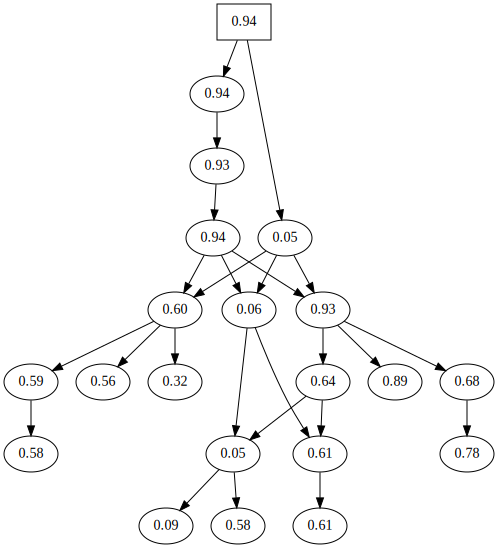

In [235]:
def build_graph(root, depth=10):
    vs = [root]
    adj = {}
    adj[root] = []
    
    if depth > 1:
        for child in nstops[root]:
            
            cvs, cadj = build_graph(child, depth-1)
            vs += cvs
            
            for stop, ls in cadj.items():
                if stop not in adj:
                    adj[stop] = []
                for ent in ls:
                    if ent not in adj[stop]:
                        adj[stop].append(ent)
                
#             adj[child].append(root)
            adj[root].append(child)
        
    return vs, adj

vs, adj = build_graph(roots[0], depth=5)

show_f = lambda vs, adj : show_graph(vs, adj, vdesc=lambda vert: ('%.2f' % (valids[vert]/13248)))
show_f(vs, adj)

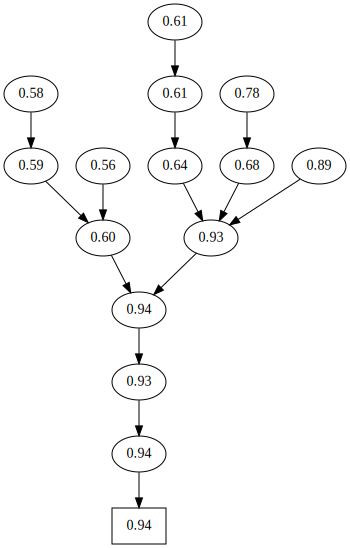

In [251]:
from utils import *
valid = lambda vert: valids[vert] / 13248

vs, adj = build_graph(roots[0], depth=5)
vs, adj = prune_graph(vs, adj, valid)
vs, adj = rev_graph(vs, adj)
show_f(vs, adj)

WARN: Majority pruned [4]: 505233-501414
WARN: Majority pruned [6]: 505233-501414
WARN: Majority pruned [7]: 505233-501414
WARN: Majority pruned [8]: 505233-501414
WARN: Majority pruned [9]: 505233-501414
WARN: Majority pruned [10]: 505233-501414
WARN: Majority pruned [9]: 500008-500009
WARN: Majority pruned [10]: 500008-500009
WARN: Majority pruned [5]: 500004-500005
WARN: Majority pruned [6]: 500004-500005
WARN: Majority pruned [7]: 500004-500005
WARN: Majority pruned [8]: 500004-500005
WARN: Majority pruned [9]: 500004-500005
WARN: Majority pruned [10]: 500004-500005
WARN: Majority pruned [5]: 500081-505233
WARN: Majority pruned [8]: 500081-505233
WARN: Majority pruned [9]: 500081-505233
WARN: Majority pruned [10]: 500081-505233
WARN: Majority pruned [6]: 503953-503932
WARN: Majority pruned [7]: 503953-503932
WARN: Majority pruned [8]: 503953-503932
WARN: Majority pruned [9]: 503953-503932
WARN: Majority pruned [10]: 503953-503932
WARN: Majority pruned [10]: 403122-404262
WARN: Majo

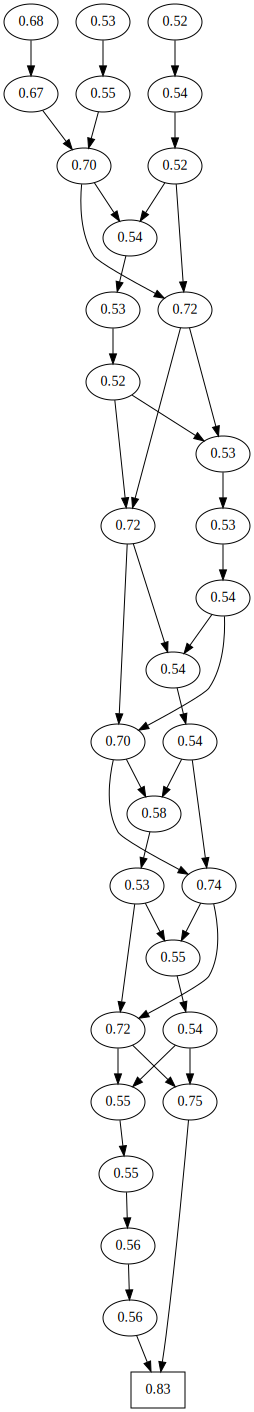

In [242]:
uniques = []
MAXD = 10
saved = None
for root in roots:
    for depth in range(1, MAXD+1):
#     for depth in range(MAXD, MAXD+1):
        vs, adj = build_graph(root, depth=depth)
        tv = len(vs)
        vs, adj = prune_graph(vs, adj, valid, minv=0.5)
        pv = len(vs)
        vs, adj = rev_graph(vs, adj)

        if MAXD > 2 and pv / tv < 0.4:
            print('WARN: Majority pruned [%d]: %s' %(depth, root))
        else:
            for vert in vs:
                if vert not in uniques:
                    uniques.append(vert)
            with open('data/graphs/%s_n%d.json' % (root, depth-1), 'w') as fl:
                obj = [
                    vs,
                    adj,
                ]
                json.dump(obj, fl, indent=4)
            
#         if '103309-101547' in vs:
#             saved = vs, adj
            
            
        
# print(__vs.index('103309-101547'))
show_f(vs, adj)   

In [232]:
print(len(uniques))

424


In [233]:
with open('data/top_allstops_2.json', 'w') as fl:
    json.dump(uniques, fl, indent=4)